In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

c:\Users\dorasir\anaconda3\envs\net-simu\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
import numpy as np
import os
from sklearn.metrics import average_precision_score
import pandas as pd
from utils.transform import clr
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation

os.chdir('d:\\microbial_network\\microbial_network_explore')

In [3]:
n_vertices = 50
avg_degree = 5

time_points = 100
time_step = 0.01
downsample = 1
noise_var = 1e-3
scale_simulation = 100

# No noise simulation

In [4]:
network_type = 'random'
# network_type = 'small-world'

interaction_type = 'random'

adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type=network_type, interaction_type=interaction_type)

In [6]:
vs = [25, 50, 100]
ds = [2, 5, 10]
ns = ['random', 'small-world', 'scale-free']

In [8]:
# score_df = pd.DataFrame(columns=['vertices', 'degree', 'type', 'mean', 'std'])
scores = []
for v, d, n in tqdm(product(vs, ds, ns)):
    adj, M = simulation.gen_graph(v, d, network_type=n, interaction_type='random')
    baseline_scores = []
    repeat = 100
    for _ in range(repeat):
        baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(v, v)) for _ in range(repeat)]), axis=2)
        baseline_score = average_precision_score(adj[~np.eye(v, dtype=bool)], baseline[~np.eye(v, dtype=bool)])
        baseline_scores.append(baseline_score)
    mu = np.mean(baseline_scores)
    sigma = np.std(baseline_scores)
    scores.append([v, d, n, mu, sigma])
score_df = pd.DataFrame(scores, columns=['vertices', 'degree', 'type', 'mean', 'std'])


27it [00:20,  1.29it/s]


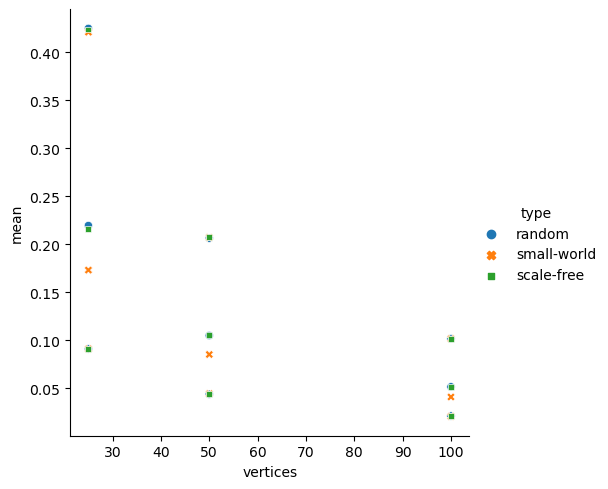

In [16]:
import seaborn as sns

sns.relplot(x='vertices', y='mean', data=score_df, hue='type', style='type')

0.105 +- 0.007


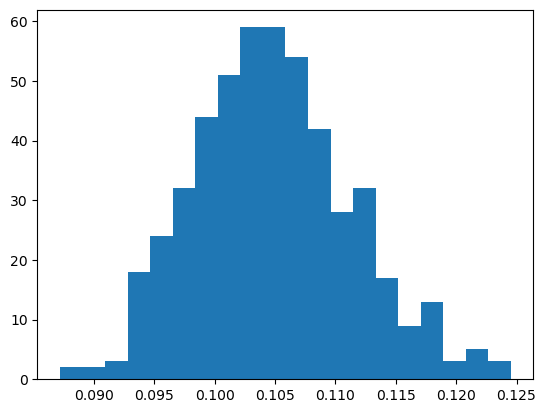

In [5]:
baseline_scores = []
repeat = 500
for _ in range(repeat):
    baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(n_vertices, n_vertices)) for _ in range(repeat)]), axis=2)
    baseline_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)])
    baseline_scores.append(baseline_score)
n, bins, _ = plt.hist(baseline_scores, bins=20)
mu = np.mean(baseline_scores)
sigma = np.std(baseline_scores)
print(f'{mu:.3f} +- {sigma:.3f}')

In [56]:
# abundances = []
# abundances_df = []
# repeat = 50
# for _ in range(repeat):
#     abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
#     abundances.append(abd)
#     abundances_df.append(pd.DataFrame(abd))

abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
abd_df = pd.DataFrame(abd)

In [57]:
# cor_scores = []
# prec_scores = []
# for i in range(repeat):
#     cor = abundances_df[i].corr().to_numpy()
#     cov = abundances_df[i].cov().to_numpy()
#     prec = np.linalg.inv(cov)

#     cor_scores.append(average_precision_score(adj.ravel(), np.abs(cor).ravel()))
#     prec_scores.append(average_precision_score(adj.ravel(), np.abs(prec).ravel()))

cor = abd_df.corr().to_numpy()
cov = abd_df.cov().to_numpy()
prec = np.linalg.inv(cov)

cor_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(cor[~np.eye(n_vertices, dtype=bool)]))
prec_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(prec[~np.eye(n_vertices, dtype=bool)]))
print(f'cor_score: {cor_score:.3f}')
print(f'prec_score: {prec_score:.3f}')

cor_score: 0.539
prec_score: 0.203


From the figure below for repeated experiments we can see that the score change for random samples is small, so we only present result of one sample to save time

0.411 +- 0.041
0.392 +- 0.047


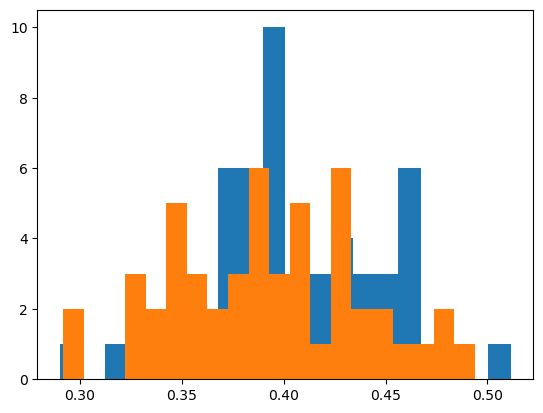

In [10]:
# n, bins, _ = plt.hist(cor_scores, bins=20)
# mu = np.mean(cor_scores)
# sigma = np.std(cor_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')
# n, bins, _ = plt.hist(prec_scores, bins=20)
# mu = np.mean(prec_scores)
# sigma = np.std(prec_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')

In [11]:
from scipy.stats import ttest_rel
ttest_rel(cor_scores, prec_scores)

TtestResult(statistic=3.5637258011527617, pvalue=0.0008266584042734103, df=49)

In [58]:
abd_clr = pd.DataFrame(clr(abd_df))
print(f"Check clr transformation: {np.allclose(abd_clr.mean(axis=1), 0) = }")
cor = abd_clr.corr().to_numpy()
cov = abd_clr.cov().to_numpy()
prec = np.linalg.inv(cov)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(cor[~np.eye(n_vertices, dtype=bool)])))
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(prec[~np.eye(n_vertices, dtype=bool)])))

Check clr transformation: np.allclose(abd_clr.mean(axis=1), 0) = True
0.14436625475330025
0.1030074670921699


In [14]:
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra

In [59]:
clv = CompositionalLotkaVolterra([abd], [np.arange(abd.shape[0])])
clv.set_regularizers(0.001, 0.001, 0.001, 0.001)
clv.train()

5042.406335373994


In [60]:
A, g, B = clv.get_params()
denom = clv.denom

In [61]:
# Remove denominator's row and column from adjacency matrix
rel_adj = np.delete(adj, denom, axis=0)

print(average_precision_score(rel_adj.ravel(), A.ravel()))

0.1177151290572712


In [49]:
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra

In [62]:
glv = GeneralizedLotkaVolterra([abd], [np.arange(abd.shape[0])])
glv.set_regularizers(0.01, 0.01, 0.01, 0.01)
glv.train()

A, g, B = glv.get_params()
print(average_precision_score(adj.ravel(), A.ravel()))

0.1252692759638779


In [63]:
%%R -i abd_df
library(ppcor)
network_pred_ppea <- abs(pcor(abd_df)$estimate)

In [64]:
import rpy2.robjects as robjects
network_pred_ppea = robjects.globalenv['network_pred_ppea']

In [65]:
network_pred_ppea = np.array(network_pred_ppea)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_ppea[~np.eye(n_vertices, dtype=bool)]))

0.39634671220967027


In [66]:
%%R -i abd
library(SpiecEasi)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [67]:
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_spiec = robjects.globalenv['network_pred_spiec']

network_pred_sparcc = np.array(network_pred_sparcc)
network_pred_spiec = np.array(network_pred_spiec)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_sparcc[~np.eye(n_vertices, dtype=bool)]))
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.23615395271559897
0.42539959898175683


In [68]:
from utils import simulation
z, x, y, _, _ = simulation.simulate_glv(time_points=time_points, downsample=downsample, adj=adj, M=M, noise=0.01)

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added


In [69]:
abd = y
abd_df = pd.DataFrame(abd)

In [70]:
cor = abd_df.corr().to_numpy()
cov = abd_df.cov().to_numpy()
prec = np.linalg.inv(cov)

cor_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(cor[~np.eye(n_vertices, dtype=bool)]))
prec_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(prec[~np.eye(n_vertices, dtype=bool)]))
print(f'cor_score: {cor_score:.3f}')
print(f'prec_score: {prec_score:.3f}')
abd_clr = pd.DataFrame(clr(abd_df))
print(f"Check clr transformation: {np.allclose(abd_clr.mean(axis=1), 0) = }")
cor = abd_clr.corr().to_numpy()
cov = abd_clr.cov().to_numpy()
prec = np.linalg.inv(cov)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(cor[~np.eye(n_vertices, dtype=bool)])))
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], np.abs(prec[~np.eye(n_vertices, dtype=bool)])))
clv = CompositionalLotkaVolterra([abd], [np.arange(abd.shape[0])])
clv.set_regularizers(0.001, 0.001, 0.001, 0.001)
clv.train()
A, g, B = clv.get_params()
denom = clv.denom
# Remove denominator's row and column from adjacency matrix
rel_adj = np.delete(adj, denom, axis=0)

print(average_precision_score(rel_adj.ravel(), A.ravel()))
glv = GeneralizedLotkaVolterra([abd], [np.arange(abd.shape[0])])
glv.set_regularizers(0.01, 0.01, 0.01, 0.01)
glv.train()

A, g, B = glv.get_params()
print(average_precision_score(adj.ravel(), A.ravel()))

cor_score: 0.110
prec_score: 0.109
Check clr transformation: np.allclose(abd_clr.mean(axis=1), 0) = True
0.1044785966193684
0.09113933991979709
4.239333375802534
0.10940391887045872
0.11281286895860837


In [71]:
%%R -i abd_df
library(ppcor)
network_pred_ppea <- abs(pcor(abd_df)$estimate)
library(SpiecEasi)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [72]:
import rpy2.robjects as robjects
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_ppea[~np.eye(n_vertices, dtype=bool)]))
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_spiec = robjects.globalenv['network_pred_spiec']

network_pred_sparcc = np.array(network_pred_sparcc)
network_pred_spiec = np.array(network_pred_spiec)

print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_sparcc[~np.eye(n_vertices, dtype=bool)]))
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.13084761080494317
0.17973156111275743
0.43771320495396376


In [73]:
%%R
network_pred_spiec <- spiec.easi(abd,method='glasso')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with glasso...

R[write to console]: done



In [74]:
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.41744088548999425
